In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from nltk.translate.bleu_score import corpus_bleu
import re
import os
import pickle
import numpy as np

2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Dataset/img_seq_data'

## Image preprocessing & Feature Extractions

In [4]:
efficientnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=None,
                    pooling=None,
                    classes=1000,
                    classifier_activation='softmax',
                    include_preprocessing=True
)

473186304/473176280 [==============================] - 9s 0us/step


In [6]:
img_dir = os.path.join(data_path, 'Images')
features = {}
count = 0

for img_name in os.listdir(img_dir):
    # image path
    img_path = os.path.join(img_dir, img_name)
    # load image
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    # reshape
    image = tf.expand_dims(image, 0)
    # feature extraction
    feature = efficientnet_model.predict(image)
    features[img_name] = feature
    
    count = count + 1
    if count%100==0:
        print(count*100/len(os.listdir(img_dir))) # percent completion

1.2359411692003461
2.4718823384006923
3.7078235076010384
4.9437646768013845
6.17970584600173
7.415647015202077
8.651588184402422
9.887529353602769
11.123470522803114
12.35941169200346
13.595352861203807
14.831294030404154
16.0672351996045
17.303176368804845
18.53911753800519
19.775058707205538
21.010999876405883
22.246941045606228
23.482882214806576
24.71882338400692
25.954764553207266
27.190705722407614
28.42664689160796
29.662588060808307
30.898529230008652
32.134470399209
33.370411568409345
34.60635273760969
35.842293906810035
37.07823507601038
38.31417624521073
39.550117414411076
40.78605858361142
42.021999752811766
43.25794092201211
44.493882091212456
45.72982326041281
46.96576442961315
48.2017055988135
49.43764676801384
50.67358793721419
51.90952910641453
53.14547027561488
54.38141144481523
55.61735261401557
56.85329378321592
58.08923495241626
59.325176121616614
60.56111729081696
61.797058460017304
63.03299962921765
64.268940798418
65.50488196761835
66.74082313681869
67.976764306

In [7]:
len(os.listdir(img_dir))

8091

In [8]:
# store features in pickle
feature_path = data_path + '/features'
pickle.dump(features, open(os.path.join(feature_path, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
feature_path = data_path + '/features'
with open(os.path.join(feature_path,'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
len(features)

8091

In [9]:
with open(os.path.join(data_path,'captions.txt'), 'r') as f:
    next(f) # don't read first line
    img_captions = f.read()

In [10]:
mapping = {}
count = 0

for line in img_captions.split('\n'):
    tmp = line.split(',')
    # clean up
    if len(tmp) <= 1:
        continue
    img_name = tmp[0]
    caption = tmp[1]    
    mapping[img_name] = caption
    
    count = count + 1
    if count%100==0:
        print(count*100/len(img_captions.split('\n')))

0.2471821237888076
0.4943642475776152
0.7415463713664228
0.9887284951552304
1.2359106189440379
1.4830927427328455
1.7302748665216532
1.9774569903104608
2.2246391140992685
2.4718212378880757
2.7190033616768834
2.966185485465691
3.2133676092544987
3.4605497330433064
3.707731856832114
3.9549139806209217
4.202096104409729
4.449278228198537
4.696460351987344
4.9436424757761515
5.19082459956496
5.438006723353767
5.685188847142575
5.932370970931382
6.17955309472019
6.426735218508997
6.673917342297805
6.921099466086613
7.16828158987542
7.415463713664228
7.662645837453035
7.909827961241843
8.15701008503065
8.404192208819458
8.651374332608265
8.898556456397074
9.145738580185881
9.392920703974688
9.640102827763496
9.887284951552303
10.134467075341112
10.38164919912992
10.628831322918726
10.876013446707534
11.123195570496343
11.37037769428515
11.617559818073957
11.864741941862764
12.111924065651571
12.35910618944038
12.606288313229188
12.853470437017995
13.100652560806802
13.34783468459561
13.5950

In [11]:
mapping

{'1000268201_693b08cb0e.jpg': 'A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg': 'Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg': 'Young girl with pigtails painting outside in the grass .',
 '1003163366_44323f5815.jpg': 'man laying on bench holding leash of dog sitting on ground',
 '1007129816_e794419615.jpg': 'The man with pierced ears is wearing glasses and an orange hat .',
 '1007320043_627395c3d8.jpg': 'The small child climbs on a red ropes on a playground .',
 '1009434119_febe49276a.jpg': 'A dog runs on the green grass near a wooden fence .',
 '1012212859_01547e3f17.jpg': 'White dog with brown ears standing near water with head turned to one side .',
 '1015118661_980735411b.jpg': 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .',
 '1015584366_dfcec3c85a.jpg': 'The black dog jumped the tree stump .',
 '101654506_8eb26cfb60.jpg': 'The white and brown dog is runni

## Preprocess Text

In [12]:
all_captions = []
for key, texts in mapping.items():
    text = " ".join([word for word in texts.split()]) # split into tokens then join
    text = re.sub('[-()\"#/@;:<>{}`+=~|.!?,]','', text)
    text = text.lower().strip().replace('\s+', ' ')
    text = 'startseq ' + text + ' endseq'
    mapping[key] = text
    all_captions.append(text)

In [13]:
mapping

{'1000268201_693b08cb0e.jpg': 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 '1001773457_577c3a7d70.jpg': 'startseq two dogs on pavement moving toward each other endseq',
 '1002674143_1b742ab4b8.jpg': 'startseq young girl with pigtails painting outside in the grass endseq',
 '1003163366_44323f5815.jpg': 'startseq man laying on bench holding leash of dog sitting on ground endseq',
 '1007129816_e794419615.jpg': 'startseq the man with pierced ears is wearing glasses and an orange hat endseq',
 '1007320043_627395c3d8.jpg': 'startseq the small child climbs on a red ropes on a playground endseq',
 '1009434119_febe49276a.jpg': 'startseq a dog runs on the green grass near a wooden fence endseq',
 '1012212859_01547e3f17.jpg': 'startseq white dog with brown ears standing near water with head turned to one side endseq',
 '1015118661_980735411b.jpg': 'startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq',
 '101

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
total_words = len(tokenizer.word_index)+1
max_length = max(len(caption.split()) for caption in all_captions)

total_words, max_length

(4341, 33)

## Train Test split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train_ids = image_ids[:split]
test_ids = image_ids[split:]
train_ids[:5], test_ids[:5]

(['1000268201_693b08cb0e.jpg',
  '1001773457_577c3a7d70.jpg',
  '1002674143_1b742ab4b8.jpg',
  '1003163366_44323f5815.jpg',
  '1007129816_e794419615.jpg'],
 ['436015762_8d0bae90c3.jpg',
  '436393371_822ee70952.jpg',
  '436608339_f1d1298770.jpg',
  '437054333_5c2761b8cd.jpg',
  '437404867_209625774d.jpg'])

In [16]:
def data_generator(keys, mapping, features, max_length, total_words, batch_size):
    x1, x2, y = list(), list(), list()
    n=0
    while 1:
        for key in keys:
            n += 1
            caption = mapping[key]
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1,len(seq)):
                input_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                input_seq = pad_sequences([input_seq], maxlen = max_length)[0]
                # encode output sequence (one hot encoding)
                out_seq = to_categorical([out_seq], num_classes=total_words)[0]
                
                # store the sequences
                x1.append(features[key][0]) # image sequence
                x2.append(input_seq)
                y.append(out_seq)
            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield [x1, x2], y
                x1, x2, y = list(), list(), list()
                n = 0

In [17]:
features['2387197355_237f6f41ee.jpg'].shape, features['2387197355_237f6f41ee.jpg'][0].shape

((1, 7, 7, 1280), (7, 7, 1280))

## Model Creation

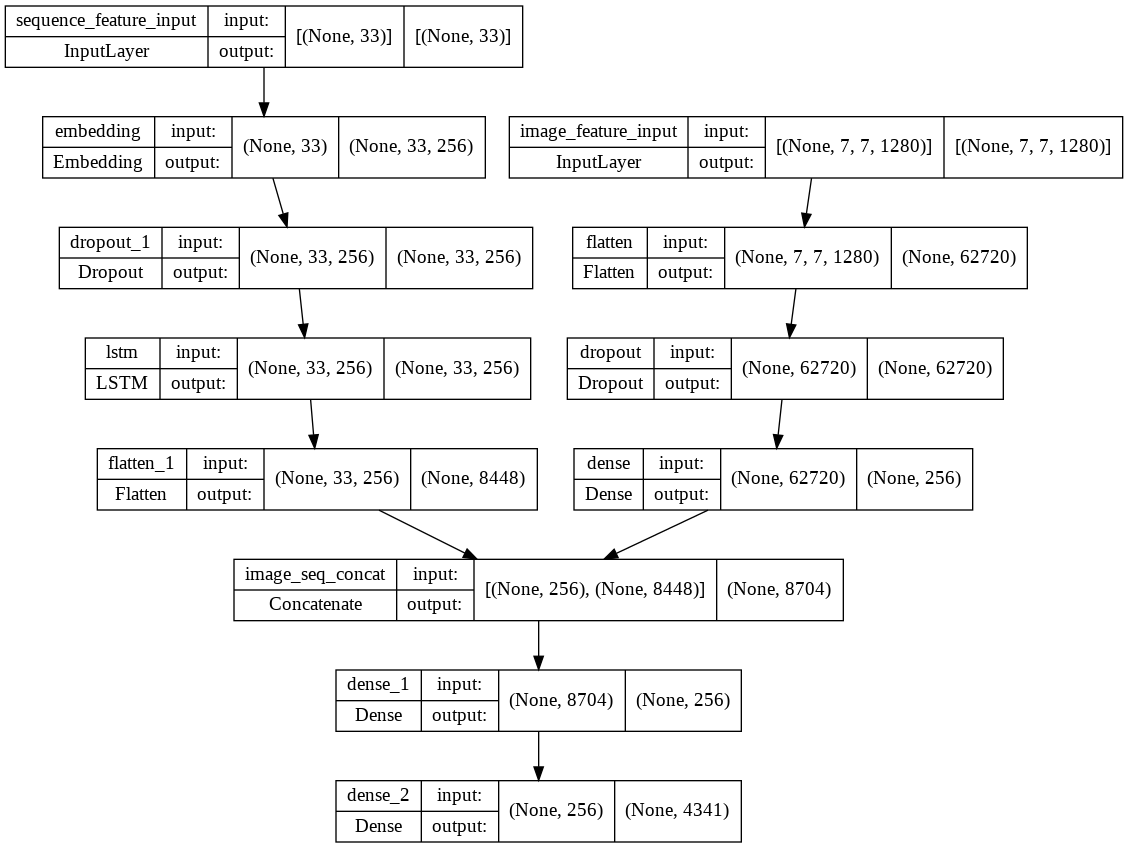

In [18]:
# image feature
input_1 = layers.Input(shape=(7,7,1280), name='image_feature_input')
x = layers.Flatten()(input_1)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
image_model = tf.keras.Model(input_1, x)

# Sequence feature
input_2 = layers.Input(shape=(max_length,), name='sequence_feature_input')
y = layers.Embedding(total_words, 256, mask_zero=True)(input_2)
y = layers.Dropout(0.2)(y)
y = layers.LSTM(256, return_sequences=True)(y)
# y = layers.LSTM(128)(y)
y = layers.Flatten()(y)
seq_model = tf.keras.Model(input_2, y)

img_seq_concat = layers.Concatenate(name='image_seq_concat')([image_model.output, seq_model.output])
decoder = layers.Dense(256, activation='relu')(img_seq_concat)
outputs = layers.Dense(total_words, activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_1, input_2], outputs=outputs, name='img_seq_model')

model.compile(loss='categorical_crossentropy',
             optimizer='adam')

plot_model(model, show_shapes=True)

## Training

In [24]:
epochs = 5
batch_size = 32
steps = len(train_ids) // batch_size

for i in range(epochs):
    generator = data_generator(train_ids, mapping, features, max_length, total_words, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 63s 279ms/step - loss: 2.8586


In [25]:
model.save(data_path + '/img_seq_model_5epochs.h5')

In [19]:
model = tf.keras.models.load_model(data_path + '/img_seq_model_5epochs.h5')

## Generate Caption

In [20]:
def get_word(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None

In [21]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag
    input_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # tokenization
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        # padding
        sequence = pad_sequences([sequence], maxlen = max_length)
        # predict
        pred = model.predict([image,sequence], verbose=0)
        
        # get index with high probability
        pred = np.argmax(pred)
        
        # turn index to word
        word = get_word(pred, tokenizer)
        
        # stop if word not found
        if word is None:
            break
        else:
        # append word as input for generating next word
          input_text = input_text + " " + word
        
        # stop if reach end tag
        if word == 'endseq':
            break
    return input_text

## Data Validation

### Calculate BLEU score

In [29]:
actual, predicted = list(), list()

for key in test_ids:
    caption = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # create a list of words
    actual_caption = caption.split()
    y_pred = y_pred.split()
    
    actual.append(actual_caption)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.080578
BLEU-2: 0.283862


## Visualization

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # Ex. image_name = "436393371_822ee70952.jpg"
    image_id = image_name
    img_path = os.path.join(data_path, "Images", image_name)
    image = Image.open(img_path)
    caption = mapping[image_id]
    print('Actual:')
    print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('\nPredicted:')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq one person in a brown suit with his arm around another in a hat by a wall endseq
--------------------Predicted--------------------
startseq overweight man with pierced shirt and orange and man endseq


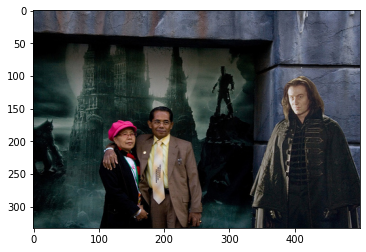

In [28]:
generate_caption("437054333_5c2761b8cd.jpg")